In [218]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import featurewiz as fw
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

In [219]:
test_data = pd.read_csv("C:\\Users\omerl\OneDrive\Documents\GitHub\Data_challenge_IML\\test_set_week_1.csv")
test_data['charge_option'] = test_data['charge_option'].apply(lambda x: 1 if x == 'Pay Now' else 0)

In [220]:
train_data = pd.read_csv('train_data.csv')
print(train_data['is_cancelled'].value_counts())

0    58113
1      475
Name: is_cancelled, dtype: int64


In [221]:
test_data = test_data.drop(['h_customer_id', 'h_booking_id', 'hotel_area_code'], axis=1)
test_data = test_data.drop(['original_payment_method', 'language','original_payment_currency'], axis=1)

In [222]:
test_data['request_nonesmoke'] = test_data['request_nonesmoke'].fillna(0)
test_data['request_earlycheckin'] = test_data['request_earlycheckin'].fillna(0)
test_data['request_latecheckin'] = test_data['request_latecheckin'].fillna(0)
test_data['request_twinbeds'] = test_data['request_twinbeds'].fillna(0)
test_data['request_largebed'] = test_data['request_largebed'].fillna(0)
test_data['request_airport'] = test_data['request_airport'].fillna(0)
test_data['request_highfloor'] = test_data['request_highfloor'].fillna(0)
test_data['no_of_extra_bed'] = test_data['no_of_extra_bed'].apply(lambda x: 1 if x>=1 else 0)
test_data = test_data.rename(columns = {'no_of_extra_bed':'request_extra_bed'})
### merge all request_* columns into one column
test_data['request_twinbeds'] = test_data['request_largebed'] + test_data['request_twinbeds'] + test_data['request_airport'] + test_data['request_highfloor'] + test_data['request_earlycheckin'] + test_data['request_latecheckin'] + test_data['request_nonesmoke']
# rename the request_twinbeds column to number_of_requests
test_data = test_data.rename(columns = {'request_twinbeds':'number_of_requests'})
test_data['number_of_requests'] = test_data['number_of_requests'].apply(lambda x: 0 if x < 1 else 1)
test_data.drop(['request_largebed', 'request_airport', 'request_highfloor', 'request_earlycheckin', 'request_latecheckin', 'request_nonesmoke'], axis=1, inplace=True)

In [223]:
dummy_cancellation = pd.get_dummies(test_data['cancellation_policy_code'],prefix="cancel_policy")
dummy_origin = pd.get_dummies(test_data['origin_country_code'], prefix="origin_country_code")
dummy_nationality = pd.get_dummies(test_data['guest_nationality_country_name'], prefix="guest_national")
dummy_hotel_type = pd.get_dummies(test_data['accommadation_type_name'], prefix="type_hotel")
dummy_brand_code = pd.get_dummies(test_data['hotel_brand_code'], prefix="hotel_brand")
dummy_chain_code = pd.get_dummies(test_data['hotel_chain_code'], prefix="hotel_chain")
dummy_city = pd.get_dummies(test_data['hotel_city_code'], prefix="hotel_city")
dummy_all = pd.concat([dummy_cancellation, dummy_origin,dummy_nationality,dummy_hotel_type,dummy_city, dummy_chain_code, dummy_brand_code], axis=1)
print(dummy_all.shape)
for col in dummy_all:
    if(col not in train_data.columns):
        dummy_all.drop([col], axis=1, inplace=True)
# concat dummy_all and test_data
print(dummy_all.shape)
test_data = pd.concat([test_data, dummy_all], axis=1)

(700, 685)
(700, 303)


In [224]:
test_data['checkin_date'] = test_data['checkin_date'].apply(pd.to_datetime)
test_data['checkout_date'] = test_data['checkout_date'].apply(pd.to_datetime)
test_data['booking_datetime'] = test_data['booking_datetime'].apply(pd.to_datetime)
# insert new column with the difference in days between the Booking_datetime and the checkin_date
test_data['Lead_day'] = (test_data['checkin_date'] - test_data['booking_datetime']).dt.days
test_data['stay_len'] = (test_data['checkout_date'] - test_data['checkin_date']).dt.days
# replace all the negative values with 0
test_data['Lead_day'] = test_data['Lead_day'].apply(lambda x: 0 if x < 0 else x)
test_data['stay_len'] = test_data['stay_len'].apply(lambda x: 0 if x < 0 else x)

In [225]:
test_data['original_payment_type'] = test_data['original_payment_type'].apply(lambda x: 0 if x == 'Credit Card' else 1)

In [226]:
test_data.drop(['cancellation_policy_code', 'checkout_date', 'origin_country_code','guest_nationality_country_name','hotel_id','hotel_live_date', 'hotel_country_code','hotel_live_date','customer_nationality', 'guest_nationality_country_name',
                 'origin_country_code'], axis=1, inplace=True)
test_data.drop(['hotel_brand_code', 'hotel_chain_code', 'hotel_city_code', 'accommadation_type_name','booking_datetime', 'checkin_date'], axis=1, inplace=True)

In [227]:
# print the shape of the train data
print(test_data.shape)

(700, 317)


In [228]:
for col in train_data.columns:
    if col == 'is_cancelled':
        continue
    if col not in test_data.columns:
        train_data.drop([col],axis=1 ,inplace=True)

In [229]:
print(test_data.shape)
print(train_data.shape)

(700, 317)
(58588, 318)


In [245]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(['is_cancelled'], axis=1), train_data['is_cancelled'], train_size=0.9, test_size=0.1, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(52729, 317) (5859, 317) (52729,) (5859,)
Index(['hotel_star_rating', 'charge_option', 'guest_is_not_the_customer',
       'no_of_adults', 'no_of_children', 'request_extra_bed', 'no_of_room',
       'original_selling_amount', 'original_payment_type', 'is_user_logged_in',
       ...
       'hotel_city_2538', 'hotel_city_2547', 'hotel_city_2561',
       'hotel_city_2567', 'hotel_city_2633', 'hotel_city_2649',
       'hotel_city_2667', 'hotel_city_2737', 'hotel_city_2797',
       'hotel_city_2799'],
      dtype='object', length=317)
False
False


In [246]:
from sklearn.linear_model import LogisticRegression
model_logistic = LogisticRegression()
model_logistic.fit(X_train, y_train)

y_pred_logistic = model_logistic.predict_proba(X_test)[:,1]

In [247]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)
y_pred_neigh = neigh.predict_proba(X_test)[:,1]

In [248]:
X_train = train_data.drop(['is_cancelled'], axis=1)
y_train = train_data['is_cancelled']
forest = RandomForestClassifier(n_estimators=190,criterion='entropy')
forest.fit(X_train, y_train)
y = forest.predict_proba(X_test)[:,1]
# prediction on the training data check if things are making sense

In [249]:
y

array([0.        , 0.        , 0.00526316, ..., 0.        , 0.        ,
       0.00526316])

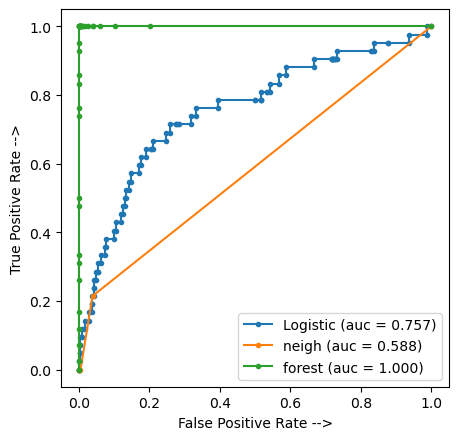

In [234]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
y_pred_logistic = y_pred_logistic
y_pred_neigh = y_pred_neigh
y_pred_forest_1= y

logistic_fpr, logistic_tpr, threshold_test = roc_curve(y_test, y_pred_logistic)
auc_logistic = roc_auc_score(y_test, y_pred_logistic)

neigh_fpr, neigh_tpr, neigh_threshold = roc_curve(y_test, y_pred_neigh)
auc_neigh = roc_auc_score(y_test, y_pred_neigh)

forest_fpr, forest_tpr, forest_threshold = roc_curve(y_test, y_pred_forest_1)
auc_forest = roc_auc_score(y_test, y_pred_forest_1)

plt.figure(figsize=(5, 5), dpi=100)
# plt.plot(svm_fpr, svm_tpr, linestyle='-', label='SVM (auc = %0.3f)' % auc_svm)
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic (auc = %0.3f)' % auc_logistic)
plt.plot(neigh_fpr, neigh_tpr, marker='.', label='neigh (auc = %0.3f)' % auc_neigh)
plt.plot(forest_fpr, forest_tpr, marker='.', label='forest (auc = %0.3f)' % auc_forest)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

In [235]:
X_train = train_data.drop(['is_cancelled'], axis=1)
y_train = train_data['is_cancelled']
forest = RandomForestClassifier(n_estimators=190,criterion='entropy')
forest.fit(X_train, y_train)
y_pred_test = forest.predict(test_data)


In [236]:

print(y_pred_test.shape)

(700,)


In [237]:
y_train_pred_forest = forest.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_train_pred_forest)
print("AUC Score is: ", roc_auc_score(y_test, y_train_pred_forest))
print('is_cancelled' in X_train.columns)
print(y_pred_test)

AUC Score is:  1.0
False
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [238]:
# pd.concat([test_data,y_pred_test], axis=1)
# after the y_pred_test is ready simply needs to concat and than write it to csv
# final_test_result =  pd.concat([test_data,y_pred_test], axis=1)
# not sure if we need to return the data after we change his features or the # original data simply after adding the y_pred_test
# final_test_result.to_csv("submission.csv")